In [35]:
import pandas as pd
import numpy as np  
from datetime import datetime 
from functions.Team_Augury_load_transform_saved import load_and_preprocess
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cla, figure
from matplotlib import pyplot
import altair as alt
from altair_saver import save
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
X_train, y_train = load_and_preprocess()
print ('Testing load, length of X, y:', X_train.shape, y_train.shape)
print ('type', type(X_train))

Loading features...
data loaded and pre_processed
Testing load, length of X, y: (1674, 776) (1674,)
type <class 'pandas.core.frame.DataFrame'>


In [16]:
# Note version differences the vanilla  pkl models created with version 0.24.2. The final pkl models are from version 1.0.2
# import sklearn
# sklearn.__version__

In [33]:
#load pkl'd SVC clf one of these will need to be hashed out
filename = "models/SVC_vanilla_model.sav" #note this is the 'Vanillia model', not the optimised tuned one, assume kernel = rbf
#filename  = "models/SVC_model_C_0_125_g_0_0078125.pkl" #this is the HPT tuned model on more data - not present?
#filename = "models/SVC_final_model.pkl" sklearn V 1.0.02 not compatible with current env
SVC_loaded = pickle.load(open(filename, 'rb'))

#test load
a_result = SVC_loaded.score(X_train, y_train)
f1_res = f1_score(y_train, SVC_loaded.predict(X_train))
print('Testing model load: Accuracy result for SVC:' , a_result)
print('Testing model load: f1 result for SVC:' , f1_res)
print (confusion_matrix(y_train, SVC_loaded.predict(X_train)) )
print (classification_report(y_train, SVC_loaded.predict(X_train), target_names=['Not hot', 'hot']) )

Testing model load: Accuracy result for GBT: 0.9097968936678614
Testing model load: f1 result for GBT: 0.7436332767402376
[[1304    3]
 [ 148  219]]
              precision    recall  f1-score   support

     Not hot       0.90      1.00      0.95      1307
         hot       0.99      0.60      0.74       367

    accuracy                           0.91      1674
   macro avg       0.94      0.80      0.84      1674
weighted avg       0.92      0.91      0.90      1674



In [4]:
#Get perm/feature importances ## NB THIS TOOK 88 mins, so written to pkl for future uses 
# perm_importance = permutation_importance(SVC_loaded, X_train, y_train)
# print (len(perm_importance))

In [20]:
filename = "models/SVM_feat_imp_bunch_object_vanilla_model.sav"
#pickle.dump(perm_importance, open(filename, 'wb')) #the code to dump it
perm_importance = pickle.load(open(filename, 'rb')) #the code to load it

In [21]:
type(perm_importance)

sklearn.utils.Bunch

In [22]:
sorted_idx = perm_importance.importances_mean.argsort()

In [23]:
len(sorted_idx)

776

In [24]:
len(X_train.columns)

776

In [25]:
features = np.array(list(X_train.columns.values))

In [11]:
## Unhash this block to create viz of feature importance for all 776 features sorted by size
# figure(figsize=(10, 80), dpi=100)
# plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")
# plt.savefig("saved_work/SVC_long_feat_imp.png")

In [26]:
bert_idx = np.flatnonzero(np.char.find(features, "bert")!=-1)
len(bert_idx)

768

In [27]:
features[388] #shows post_sbert are 5:388 and comments sbert are 392:775 in between are 389:392

'post_sbert_384'

In [28]:
sbert_post_sum = np.sum(perm_importance.importances_mean[5:388])
sbert_comm_sum = np.sum(perm_importance.importances_mean[392:775])
print (sbert_post_sum, sbert_comm_sum)

0.37132616487456205 0.12162485065711344


In [29]:
# Having located the sbert items they now need removing from both feature names and scoring arrays
ind = np.indices(features.shape)[0]
mylist=(slice(5,389),slice(392,776))
rm = np.hstack([ind[i] for i in mylist])
simplified_names = np.take(features, sorted(set(ind)-set(rm)))
print(simplified_names) # should be small enough for visual confirmation
simplified_fi_scores = np.take(perm_importance.importances_mean, sorted(set(ind)-set(rm)) )
print (simplified_fi_scores)

['post_author_karma' 'number_comments_vs_hrs' 'post_sentiment' 'time_hour'
 'day_of_week' 'avg_comment_upvotes_vs_hrs' 'avg_comment_author_karma'
 'avg_comment_sentiment']
[ 0.00657109  0.01015532 -0.00023895  0.00728793  0.00549582  0.01565114
  0.00669056  0.00059737]


In [30]:
#Now just need to add sbert agregated names and scores to each array
sb_simplified_names = np.append(simplified_names, ['SBERT_Post','SBERT_Comment_Avg'])
sb_simplified_fi_scores = np.append(simplified_fi_scores, [sbert_post_sum, sbert_comm_sum]) 
sb_sorted_idx = np.argsort(sb_simplified_fi_scores)

In [31]:
sb_sorted_idx

array([2, 7, 4, 0, 6, 3, 1, 5, 9, 8])

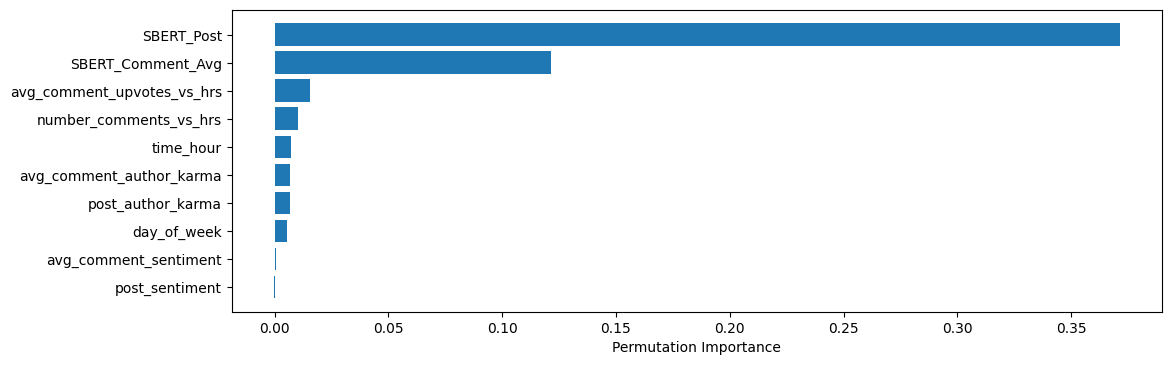

In [32]:
figure(figsize=(12, 4), dpi=100)
#plt.tight_layout()
plt.barh(sb_simplified_names[sb_sorted_idx], sb_simplified_fi_scores[sb_sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig("saved_work/SVC_simple_feat_imp.jpg", bbox_inches='tight')#note works for .jpg but fails for .png

In [34]:
# Repeat of much of the above for LR

filename = "models/LogisticRegression_vanilla_model.sav" #note this is the 'Vanillia model', not the optimised tuned one
LR_loaded = pickle.load(open(filename, 'rb'))

#test load
a_result = LR_loaded.score(X_train, y_train)
f1_res = f1_score(y_train, LR_loaded.predict(X_train))
print('Testing model load: Accuracy result for LR:' , a_result)
print('Testing model load: f1 result for LR:' , f1_res)
print (confusion_matrix(y_train, LR_loaded.predict(X_train)) )
print (classification_report(y_train, LR_loaded.predict(X_train), target_names=['Not hot', 'hot']) )

Testing model load: Accuracy result for GBT: 0.9324970131421745
Testing model load: f1 result for GBT: 0.8320950965824666
[[1281   26]
 [  87  280]]
              precision    recall  f1-score   support

     Not hot       0.94      0.98      0.96      1307
         hot       0.92      0.76      0.83       367

    accuracy                           0.93      1674
   macro avg       0.93      0.87      0.89      1674
weighted avg       0.93      0.93      0.93      1674



805


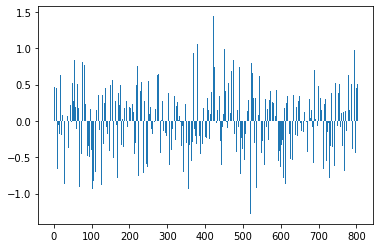

In [44]:
importance = LR_loaded.steps[1][1].coef_
print (len(importance[0]))

# summarize feature importance
# for i,v in enumerate(importance[0]):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance[0]))], importance[0])
pyplot.show()

In [45]:
#backlog
# scale the array to range{0:1}
# determine labels for transformed 805 features
# aggregate SBERT post and comment scores
# viz


In [46]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [47]:
scaled_fimp = NormalizeData(importance[0])

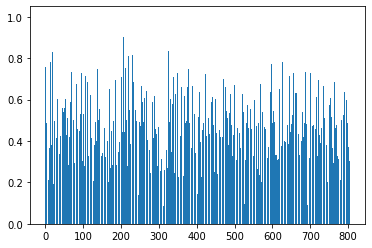

In [49]:
pyplot.bar([x for x in range(len(scaled_fimp))], scaled_fimp)
pyplot.show()

In [51]:
def reduce_fimp(data):
    return data/np.sum(data)
fimp = reduce_fimp(scaled_fimp)
print (np.sum(fimp))

1.0


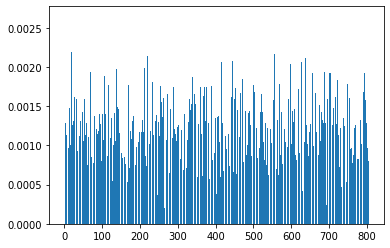

In [52]:
pyplot.bar([x for x in range(len(fimp))], fimp)
pyplot.show()

In [53]:
#Step 2 labels
clabels_v2 = list(X_train.columns)
clabels_v2.remove('time_hour')
clabels_v2.remove('day_of_week')

clabels_v2 = clabels_v2[0:3] + clabels_v2[387:390] + list(LR_loaded['preprocessor'].transformers_[1][1]['onehot'].get_feature_names()) + clabels_v2[3:387]+clabels_v2[390:]

In [54]:
first_six_scores = fimp[0:6]
hours_and_days = fimp[6:37]
sbert_post = fimp[37:421]
sbert_comment = fimp[421:806]
#test lengths
print ('Testing length of feature groups: should be 6,31,384,384.',len(first_six_scores), len(hours_and_days), len(sbert_post), len(sbert_comment))

sbert_post    = np.array([np.sum(sbert_post)])
sbert_comment = np.array([np.sum(sbert_comment)])

#create new labels and array of scores
scoring_array = np.concatenate(
  (first_six_scores,
  hours_and_days,
  sbert_post,
  sbert_comment),
  axis=None
)

Testing length of feature groups: should be 6,31,384,384. 6 31 384 384


In [59]:
short_label_list = clabels_v2[0:37] + ['SBERT_posts', 'SBERT_comments']
new_combined_ns = (zip(short_label_list,scoring_array))
df = pd.DataFrame(new_combined_ns, columns=['Feature','Importance'])
#print (df)


chart = alt.Chart(df).mark_bar().encode(
  x = 'Feature:N',
  y = 'Importance:Q'
).properties(
    title='Feature importances for Logistic Regression classifier'
)

save(chart, "saved_work/lr_feat_imp_short.png")


In [60]:
chart

alt.Chart(...)